
# <center><u>**`Ensemble ML Algorithms - Boosting`**</u></center>




## **`TalkingData: Fraudulent Click Prediction`**






In this assignment, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.

The analysis is divided into the following sections:
- `Understanding the business problem`
- `Understanding and exploring the data`
- `Feature engineering: Creating new features`
- `Model building and evaluation: AdaBoost`
- `Modelling building and evaluation: Gradient Boosting`
- `Modelling building and evaluation: XGBoost`
- `Modelling building and evaluation: LightGBM`
- `Modelling building and evaluation: CatBoost`




## **`Understanding the Business Problem`**

<p style='text-align: right;'> 5 points</p>


<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## **`Understanding and Exploring the Data`**

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
#importing important libraries

import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

#### `Reading the Data` 

The code below reads the train_sample.csv file if you set testing = True, else reads the full train.csv file. You can read the sample while tuning the model etc., and then run the model on the full data once done.

#### `Important Note: Save memory when the data is huge`

Since the training data is quite huge, the program will be quite slow if you don't consciously follow some best practices to save memory. This notebook demonstrates some of those practices. 

In [3]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
# note that click_id is only in test data, not training data
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' 
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data (train_sample.csv)
train_sample = pd.read_csv("train_sample.csv")





In [4]:
# Printing length of training data

len(train_sample)


100000

To get memory consumed by each column use memory_usage() function on train_sample

Refer: https://www.w3resource.com/pandas/dataframe/dataframe-memory_usage.php

In [5]:
# Displays memory consumed by each column ---
train_sample.memory_usage()



Index                 132
ip                 800000
app                800000
device             800000
os                 800000
channel            800000
click_time         800000
attributed_time    800000
is_attributed      800000
dtype: int64

To get space used by training data then use sum of memory consumed by each variable divided by 1024**2


In [6]:
# space used by training data
print("Training dataset uses",train_sample.memory_usage().sum()/1024**2,"MB")




Training dataset uses 6.103641510009766 MB


In [7]:
# training data top rows
train_sample.head()
train_sample.drop('attributed_time',axis=1,inplace=True)



### `Exploring the Data - Univariate Analysis`


Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [8]:
# look at non-null values, null values, number of entries etc.
train_sample.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


You can see that there is no missing values

## `Basic exploratory analysis `

<p style='text-align: right;'> 10 points</p>


1. Number of unique values in each column


In [9]:
# Define a function to fetch unique values in each column
def fraction_unique(x):
    # return unique values
    return len(train_sample[x].unique())

# one line code to use above function and creating a dictionary
number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}



#print dictionary of Unique values
number_unique_vals





{'ip': 34857,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

2. Checking data type of each columns

In [10]:
# each column data type
train_sample.dtypes





ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

You will see that all columns apart from click time are originally int type, though note that they are all actually categorical 

There are certain 'apps' which have quite high number of instances/rows (each row is a click). So lets plot it below 

<Axes: xlabel='app', ylabel='count'>

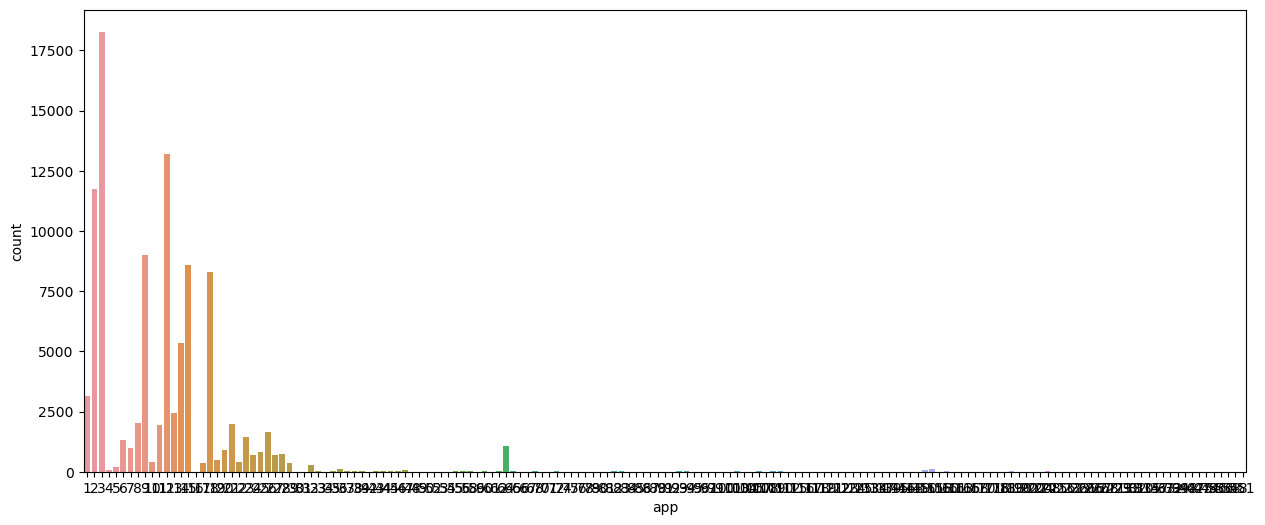

In [11]:
#distribution of 'app' 
plt.figure(figsize=(15, 6))
sns.countplot(x="app",data=train_sample)




some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)

Let us now plot device distribution below 

<Axes: xlabel='device', ylabel='count'>

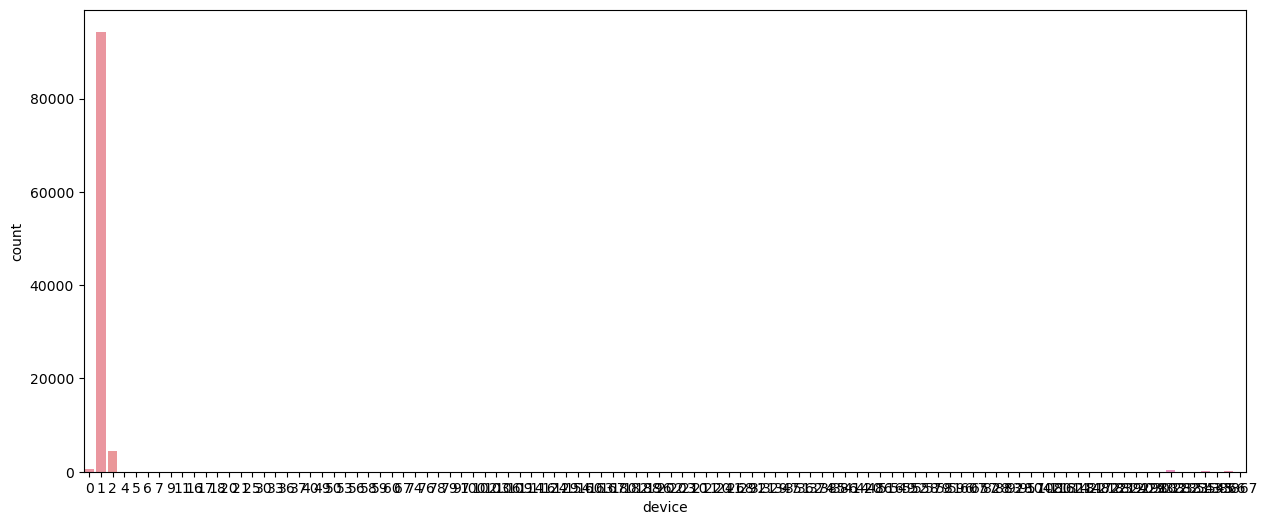

In [12]:
# distribution of 'device' 
plt.figure(figsize=(15, 6))
sns.countplot(x='device',data=train_sample)





The above result is expected because a few popular devices are used heavily

Let us now plot channel below

<Axes: xlabel='channel', ylabel='count'>

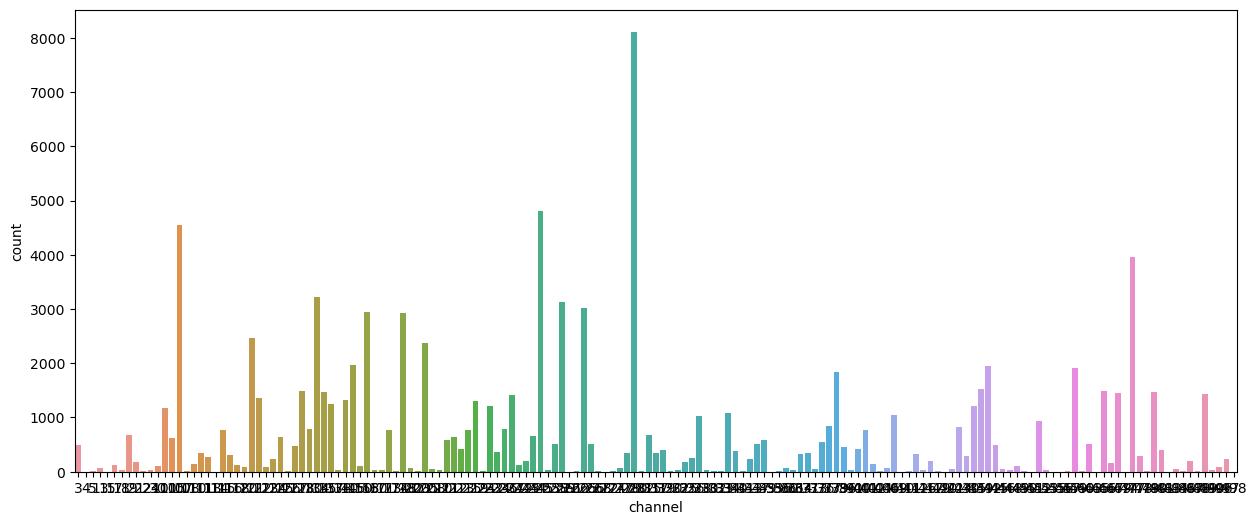

In [13]:
# distribution of 'channel' 

plt.figure(figsize=(15, 6))
sns.countplot(x='channel',data=train_sample)






you can see abobe that various channels get clicks in comparable quantities

Lets see distribution of 'os' now 

<Axes: xlabel='os', ylabel='count'>

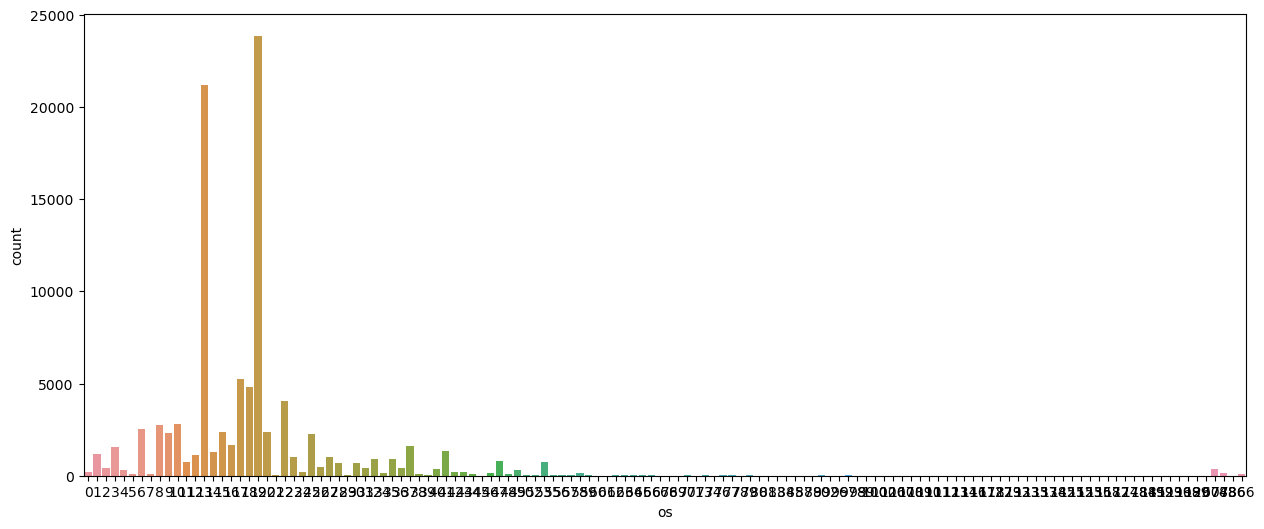

In [14]:
# distribution of 'os' 

plt.figure(figsize=(15, 6))

sns.countplot(x='os',data=train_sample)





there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 


Let's now look at the distribution of the target  variable 'is_attributed'.

In [15]:
# target variable distribution
(train_sample['is_attributed'].value_counts()/len(train_sample.index))*100




is_attributed
0    99.773
1     0.227
Name: count, dtype: float64

Only **about 0.2% of clicks are 'fraudulent'**, which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

### **`Exploring the Data - Segmented Univariate Analysis`**

Let's now look at how the target variable varies with the various predictors.

In [16]:
# Get average of 'is_attributed', or 'download rate' grouped with app
app_target = train_sample.groupby('app').is_attributed.agg(['mean','count'])



# print app_target
app_target




,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [17]:
# Make a 'count' column based on app size and reset index on count
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')



# filter count greater than count above 80% quantile range
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]



#inner join frequent_apps with train_sample on 'app'
frequent_apps = frequent_apps.merge(train_sample,on='app',how='inner')




#print head of frequent_apps
frequent_apps.head()




,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


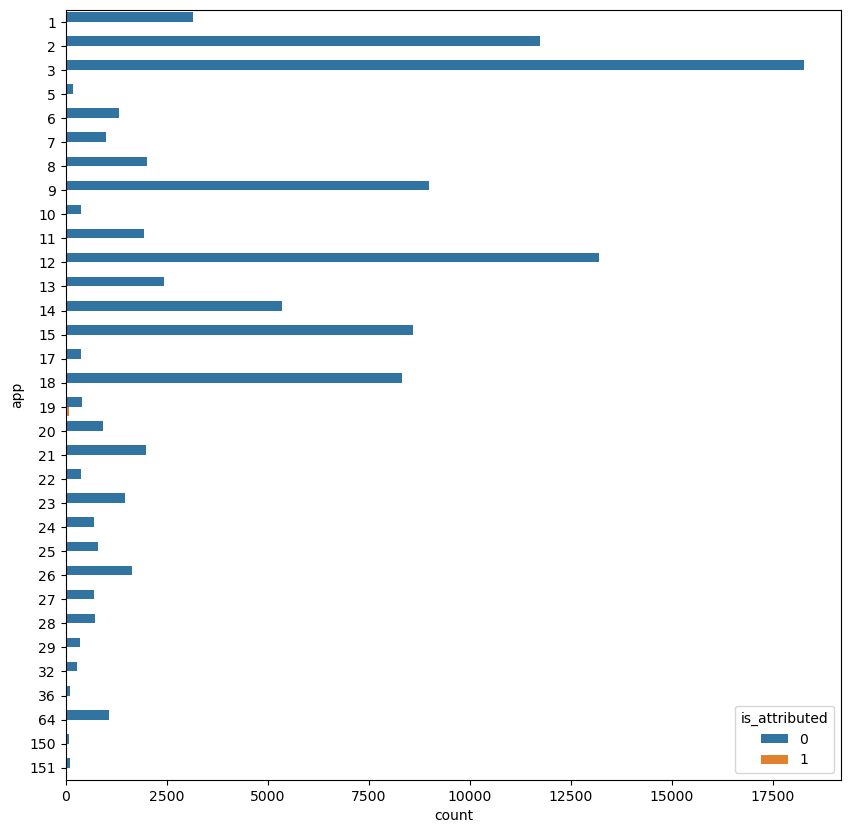

In [18]:
#plot count distribution of 'app' hued with 'is_attributed'
plt.figure(figsize=(10,10))
sns.countplot(y='app',hue='is_attributed',data=frequent_apps)
plt.show()



You can do lots of other interesting ananlysis with the existing features. For now, let's create some new features which will probably improve the model.

## **`Feature Engineering`**

<p style='text-align: right;'> 10 points</p>


Let's now derive some new features from the existing ones. There are a number of features one can extract from ```click_time``` itself, and by grouping combinations of IP with other features.

### Datetime Based Features


In [19]:
# Create a function which takes in a df, adds date/time based columns to it and returns the modified df

def timeFeatures(df):
    # Creating datetime variables using the click_time column 
    df['datetime'] = pd.to_datetime(df['click_time'])
    
    
    #Creating day_of_week variables extracting week from the datetime column 

    df['day_of_week'] = df['datetime'].dt.dayofweek
    
    
     #Creating day_of_year variables extracting day from the datetime column 

    df["day_of_year"] = df['datetime'].dt.dayofyear
    
    
    #Creating month variables extracting month from the datetime column 

    df["month"] = df['datetime'].dt.month
    
    
    #Creating hour variables extracting hour from the datetime column 

    df["hour"] = df['datetime'].dt.hour
    
    
    #return df
    return df
    

In [20]:
# creating new variables using above function with df as train_sample 
train_sample =timeFeatures(train_sample)

# dropping the click_time and datetime variables from train_sample
train_sample.drop(['click_time','datetime'],axis=1,inplace=True)



#print train_sample head
train_sample.head()




,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


In [21]:
# datatypes  of all variables in train_sample
train_sample.dtypes




ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int32
day_of_year      int32
month            int32
hour             int32
dtype: object

note that by default the new datetime variables are int64


In [22]:
# check memory/space used by training data

print("Training dataset uses",train_sample.memory_usage().sum()/1024**2,"MB")




Training dataset uses 6.103641510009766 MB


Lets convert the variables back to lower dtype again


In [23]:
# get all int variables in a list
int_vars =['app', 'device', 'os', 'channel', 'day_of_week',
       'day_of_year', 'month', 'hour']

# convert all above variables into uint16 type
train_sample[int_vars]=train_sample[int_vars].astype('uint16')

train_sample['ip']=train_sample['ip'].astype('uint16')
train_sample['is_attributed']=train_sample['is_attributed'].astype('uint8')

In [24]:
#print datatype of all variables in train_sample

train_sample.dtypes



ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [25]:
# space used by training data
print("Training dataset uses",train_sample.memory_usage().sum()/1024**2,"MB")





Training dataset uses 1.8121070861816406 MB


Hope you undertood why we converted variables into uint16 datatype

Yes, you are right:) The primitive data types prefixed with "u" are unsigned versions with the same bit sizes. Effectively, this means they cannot store negative numbers, but on the other hand they can store positive numbers twice as large as their signed counterparts. 

This is why it saves memory usage.

### **`IP Grouping Based Features`**

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

`number of clicks by count of IP address
Note that we are explicitly asking pandas to re-encode the aggregated features as 'int16' to save memory`

In [26]:
# Create a column 'ip_count' using number of clicks by count of IP address 
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int')


#print head of ip_count 
ip_count.head()



,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc. 

The following function takes in a dataframe and creates these features.

In [27]:
'''creates groupings of IP addresses with other features and appends the new features to the df'''

def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint')

    
    # ip_day_hour
    ip_day_hour =df.groupby(['ip','day_of_week','hour']).size().reset_index(name='ip_day_hour').astype('uint16')

#   ip_hour_channel
    ip_hour_channel = df[['ip','hour','channel']].groupby(['ip','hour','channel']).size().reset_index(name='ip_hour_channel').astype('uint16')

    
#   ip_hour_os
    ip_hour_os = df.groupby(['ip','hour','os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')

    
#   ip_hour_app
    ip_hour_app =df.groupby(['ip','hour','app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')

    
#   ip_hour_device
    ip_hour_device = df.groupby(['ip','hour','device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')

    
    
    '''merge the new aggregated features with the df'''
    
#   left join ip_count to df on ip
    df =pd.merge(df,ip_count,on='ip',how='left')
    
    
#   delete ip_count
    del ip_count
    
    
    #left join ip_day_hour to df on ip, day_of_week and hour

    df =pd.merge(df,ip_day_hour,on=['ip','day_of_week','hour'],how='left')
    
    
    #delete ip_day_hour

    
    del ip_day_hour
    
#   left join ip_hour_channel to df on ip, hour, channel
    df =pd.merge(df,ip_hour_channel,on=['ip','hour','channel'],how='left')
    del ip_hour_channel

    
    
    #left join ip_hour_os to df on ip, hour and os
    df =pd.merge(df,ip_hour_os,on=['ip','hour','os'],how='left')
    del ip_hour_os

    
    
    #    left join ip_hour_app to df on ip, hour and app
    df =pd.merge(df,ip_hour_app,on=['ip','hour','app'],how='left')
    del ip_hour_app
    #left join ip_hour_device to df on ip , hour and device
    df =pd.merge(df,ip_hour_device,on=['ip','hour','device'],how='left')
    del ip_hour_device
#  return 
    return df
    

In [28]:
#Use above grouped_features() function with train_sample as parameter to create your new train_sample data 
train_sample = grouped_features(train_sample)



In [29]:
#print head of train_sample
train_sample.head()



,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [30]:
#check space usage of train_sample again
print("Training dataset uses",train_sample.memory_usage().sum()/1024**2,"MB")





Training dataset uses 3.5287208557128906 MB


In [31]:
# garbage collect (unused) object using gc.collect()
gc.collect()



8659

## **`Modelling`**

<p style='text-align: right;'> 75 points</p>


Let's now build models to predict the variable ```is_attributed``` (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost, LightGBM and Catboost), tune the hyperparameters in each model and choose the one which gives the best performance.

In the original Kaggle competition, the metric for model evaluation is **area under the ROC curve**.


In [32]:
# create X and y train
X = train_sample.drop('is_attributed',axis=1)

y = train_sample['is_attributed']



# split data into train and test/validation sets with test_size as 20% and random state as 101
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)


#print shape of X_train, y_train, X_test and y_test
print(X_train.shape)






(80000, 15)


In [33]:
# check the average download rates in train 
print(y_train.mean())





# check the average download rates in test data, and check they should be comparable
print(y_test.mean())






0.002275
0.00225


### **`1.  AdaBoost`**

Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Reference video below:

AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique that is used as an Ensemble Method in Machine Learning. It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights to incorrectly classified instances. Boosting is used to reduce bias as well as the variance for supervised learning. It works on the principle where learners are grown sequentially. Except for the first, each subsequent learner is grown from previously grown learners. In simple words, weak learners are converted into strong ones. Adaboost algorithm also works on the same principle as boosting, but there is a slight difference in working. 

# **`WATCH ALL VIDEOS IN THE PORTAL`**

## **`Watch Video 1 : Boosting Intuition`**

## **`Watch Video 2 : Adaptive Boosting`**

In [34]:
# Instantiate DecisionTreeClassifier with max_depth as 2 and random state as 1
tree = DecisionTreeClassifier(max_depth=2,random_state=1)


'''adaboost with the tree as base estimator, max 600 decision trees of depth=2, 
learning_rate/shrinkage=1.5 and algorithm as "SAMME" and random_state as 1'''

adaboost_model_1 = AdaBoostClassifier(base_estimator=tree,
                                     n_estimators=600,
                                     learning_rate=1.5,
                                     algorithm="SAMME",
                                     random_state=1)






In [35]:
# fit adaboost_model_1 with training dataset

adaboost_model_1.fit(X_train,y_train)




AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.5, n_estimators=600, random_state=1)

In [36]:
# prediction probability on X_test
predictions =adaboost_model_1.predict_proba(X_test)



#print top 10 prediction result
predictions[:10]




array([[0.54049582, 0.45950418],
       [0.53588662, 0.46411338],
       [0.53885559, 0.46114441],
       [0.52427816, 0.47572184],
       [0.52018053, 0.47981947],
       [0.5308397 , 0.4691603 ],
       [0.53055748, 0.46944252],
       [0.54126954, 0.45873046],
       [0.52347347, 0.47652653],
       [0.51624249, 0.48375751]])

In above result the second column represents the probability of a click resulting in a download


In [37]:
# metrics: Get AUC score with parameters y_test and predicted probability result
metrics.roc_auc_score(y_test,predictions[:,1])





0.9523839750549848

### **`AdaBoost - Hyperparameter Tuning`**

Let's now tune the hyperparameters of the AdaBoost classifier. In this case, we have two types of hyperparameters - those of the component trees (max_depth etc.) and those of the ensemble (n_estimators, learning_rate etc.). 


We can tune both using the following technique - the keys of the form ```base_estimator_parameter_name``` belong to the trees (base estimator), and the rest belong to the ensemble.

In [38]:
# parameter grid with base_estimator__max_depth as [2,5] and n_estimators as [200, 400, 600]
param_grid = {" base_estimator__max_depth":[2,5],
              "n_estimators":[200, 400, 600]
}






In [42]:
# DecisionTreeClassifier as base estimator with random_state=1
tree = DecisionTreeClassifier(random_state=1)




'''adaboost with the tree as base estimator and learning rate is arbitrarily set to 0.6, 
we'll discuss learning_rate below and algorithm as "SAMME"'''

ABC = AdaBoostClassifier(base_estimator=tree,
                                     n_estimators=600,
                                     learning_rate=1.5,
                                     algorithm="SAMME",
                                     random_state=1)






#### Run grid search CV


In [43]:
# Keep cross validation fold as 3
folds = 3

# run grid search with ABC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1
grid_search_ABC = GridSearchCV(ABC,
                              cv=folds,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              return_train_score=True,
                              verbose=1)







In [44]:
# fit grid_search_ABC on training data
grid_search_ABC.fit(X_train,y_train)





Fitting 3 folds for each of 6 candidates, totalling 18 fits


ValueError: Invalid parameter ' base_estimator' for estimator AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(random_state=1),
                   learning_rate=1.5, n_estimators=600, random_state=1). Valid parameters are: ['algorithm', 'base_estimator', 'estimator', 'learning_rate', 'n_estimators', 'random_state'].

In [ ]:
# cv results
cv_results = 

# print cv_results




In [ ]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = 
    
    # plot depth_df["param_n_estimators"] for depth_df["mean_test_score"],depth_df["mean_train_score"] 
    
    
    

    


The results above show that:
- The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
- At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score 

Thus, we should go ahead with ```max_depth=2``` and ```n_estimators=200```.

Note that we haven't experimented with many other important hyperparameters till now, such as ```learning rate```, ```subsample``` etc., and the results might be considerably improved by tuning them. We'll next experiment with these hyperparameters.

As of now again rebuild AdaBoostClassifier with chosen hyperparameters

In [45]:
# DecisionTreeClassifier  as base estimator with max_depth as 2 and random_state as 1
tree = DecisionTreeClassifier(max_depth=2,random_state=1)


'''adaboost with the tree as base estimator
# learning rate is arbitrarily set as 0.6, n_eastimator as 200 and rest same'''

ABC = AdaBoostClassifier(base_estimator=tree,
                        learning_rate=0.6,
                        n_estimators=200,
                        algorithm='SAMME',
                        random_state=1)




# fitting ABCon training data
ABC.fit(X_train,y_train)




AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.6, n_estimators=200, random_state=1)

In [46]:
# predict on test data
predictions = ABC.predict_proba(X_test)


# print top 10 prediction probabilities

print(predictions[:10])


[[0.61058431 0.38941569]
 [0.60742586 0.39257414]
 [0.63265753 0.36734247]
 [0.58758342 0.41241658]
 [0.57045678 0.42954322]
 [0.61162484 0.38837516]
 [0.59403993 0.40596007]
 [0.60805124 0.39194876]
 [0.60362848 0.39637152]
 [0.57654304 0.42345696]]


In [48]:
# Calculate roc auc score 


print(metrics.roc_auc_score(y_test,predictions[:,1]))


0.960727748545338


Well done, you have improved the model and adaboost gave us 96% of roc_auc coverage, which is a kind of good coverage

### **`2. Gradient Boosting Classifier`**



Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. 

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - ```learning_rate``` (shrinkage) and ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

## **`Watch Video 3: Gradient Boosting Intuition`**

In [49]:
# parameter grid with learning_rate as [0.2, 0.6, 0.9] and subsample as [0.3, 0.6, 0.9]
param_grid = {'learning_rate':[0.2, 0.6, 0.9],
             'subsample':[0.3, 0.6, 0.9]}




In [50]:
# Gradient boost as base estimator with max_depth as 2 and n_estimators as 200 and random_state as 1
GBC = GradientBoostingClassifier(max_depth=2,n_estimators=200,random_state=1)





##### Run grid search


In [51]:
# CV folds as 3
folds = 3

#Instantiate grid search with GBC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1

grid_search_GBC = GridSearchCV(GBC,
                              cv=folds,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              return_train_score=True,
                              verbose=1
                              )






# grid_search_GBC fit on training data 

grid_search_GBC.fit(X_train,y_train)




Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2, n_estimators=200,
                                                  random_state=1),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [53]:
# cv results

cv_results = pd.DataFrame(grid_search_GBC.cv_results_)


# print head

cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.382448,0.006981,0.019229,0.000436,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.777579,0.667045,0.884576,0.776400,0.088811,3,0.848509,0.771451,0.843124,0.821028,0.035125
1,4.086157,0.018254,0.019462,0.000873,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.880967,0.878957,0.751848,0.837257,0.060399,2,0.905836,0.949851,0.741464,0.865717,0.089679
2,5.473053,0.017695,0.019415,0.000539,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.799695,0.823715,0.899856,0.841089,0.042696,1,0.858151,0.815856,0.904002,0.859336,0.035995
3,2.409805,0.014804,0.019329,0.000729,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.712614,0.171713,0.632072,0.505466,0.238279,7,0.617595,0.177567,0.654294,0.483152,0.216600
4,4.138398,0.015048,0.019712,0.000899,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.489959,0.654872,0.603384,0.582738,0.068890,6,0.452552,0.684572,0.634142,0.590422,0.099639


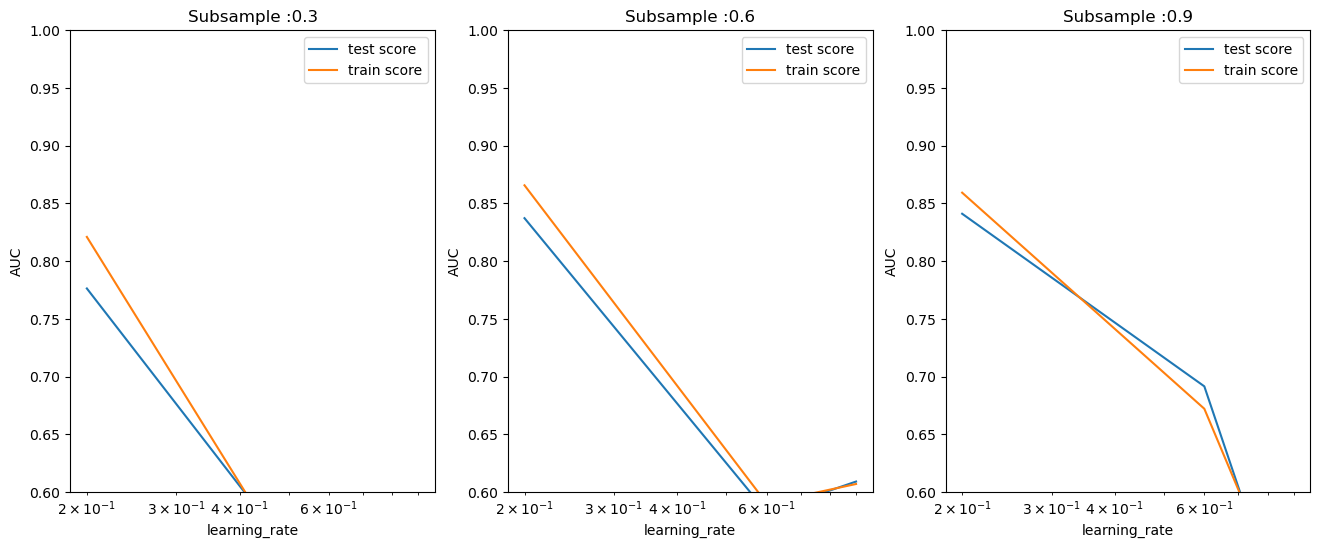

In [56]:
# # plotting AUC with hyperparameter combinations i.e subsample

plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]
    
    # plot df["param_learning_rate"] for df["mean_test_score"], df["mean_train_score"
    plt.plot(df['param_learning_rate'],df['mean_test_score'])
    plt.plot(df['param_learning_rate'],df['mean_train_score'])
    plt.xlabel("learning_rate")
    plt.ylabel("AUC")
    plt.title("Subsample :{0}".format(subsample))
    plt.legend(["test score","train score"])
    plt.ylim([0.6,1])
    plt.xscale('log')

    


It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit. 

Also, a lower learning rate results in less overfitting.

In [57]:
# fitting GBC training data
GBC.fit(X_train,y_train)




# predict probabilities on test data
predictions = GBC.predict_proba(X_test)


# print top 10 prediction probabilities
predictions[:10]



array([[9.99759635e-01, 2.40365249e-04],
       [9.99683461e-01, 3.16539468e-04],
       [9.99385527e-01, 6.14472923e-04],
       [9.99790280e-01, 2.09720179e-04],
       [9.99189954e-01, 8.10045513e-04],
       [9.99824758e-01, 1.75242409e-04],
       [9.99618179e-01, 3.81820940e-04],
       [9.99712348e-01, 2.87651814e-04],
       [9.99781825e-01, 2.18175325e-04],
       [9.98997601e-01, 1.00239939e-03]])

In [58]:
# Calculate roc auc score 
metrics.roc_auc_score(y_test,predictions[:,1])




0.9599148083187171

So Gradient boosting also gives us 96% of roc_auc coverage

### **`3. XGBoost`**


Reference doc:https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. Please see the chart below for the evolution of tree-based algorithms over the years.

Let's finally try XGBoost. The hyperparameters are the same, some important ones being ```subsample```, ```learning_rate```, ```max_depth``` etc.

Reference video below


## **`Watch Video 4 : XGBOOST Intuition`**

In [59]:
# Instantiate XGBClassifier with default hyperparameters and random_state=1
model =XGBClassifier(random_state=1) 

 
# fit model on training data
model.fit(X_train,y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

Make predictions for test data


In [60]:
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)



#print top 10 y_pred result

y_pred[:10]



array([[9.9999762e-01, 2.3850384e-06],
       [9.9997681e-01, 2.3205019e-05],
       [9.9999285e-01, 7.1295767e-06],
       [9.9978524e-01, 2.1477159e-04],
       [9.9994248e-01, 5.7545258e-05],
       [9.9999696e-01, 3.0614756e-06],
       [9.9992359e-01, 7.6433542e-05],
       [9.9999708e-01, 2.9036298e-06],
       [9.9962950e-01, 3.7048370e-04],
       [9.9869585e-01, 1.3041229e-03]], dtype=float32)

In [61]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test,y_pred[:,1])


# print AUC
roc




0.9504139870263649

The roc_auc in this case is about 0.95% with default hyperparameters. Let's try changing the hyperparameters - an exhaustive list of XGBoost hyperparameters is here: http://xgboost.readthedocs.io/en/latest/parameter.html


Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

In [68]:
# hyperparameter tuning with XGBoost

# creating a KFold object( 3 )
folds = 3

# specify range of hyperparameters with learning_rate as [0.2, 0.6] ans subsample as [0.3, 0.6, 0.9]
param_grid ={"learning_rate":[0.2, 0.6],
            "subsample":[0.3, 0.6, 0.9]}




# specify model with max_depth as 2 and n_estimators as 200 and random_state as 1
xgb_model = XGBClassifier(max_depth=2,
                         n_estimator=200,random_state=1)




# set up GridSearchCV() with xgb_model, param_grid, folds, return_train_score and verbose as 1
model_cv = GridSearchCV(xgb_model,
                       param_grid,
                       cv=folds,
                       scoring="roc_auc",
                       return_train_score=True,
                       verbose=1)






In [69]:
# fit the model_cv on training data
model_cv.fit(X_train,y_train)





Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimator=200,
                                     n_estimators=None, n_jobs=None,
                                     num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [70]:
# Get cv results as datafame
cv_results =pd.DataFrame( model_cv.cv_results_)


# print cv_results
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.099275,0.002380,0.011357,0.000082,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.927506,0.974830,0.943358,0.948564,0.019668,4,0.982558,0.972479,0.985376,0.980138,0.005536
1,0.111710,0.007441,0.009635,0.000738,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.935579,0.968116,0.955419,0.953038,0.013389,2,0.982628,0.973828,0.982017,0.979491,0.004012
2,0.100672,0.004863,0.011180,0.001990,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.937951,0.973816,0.954680,0.955483,0.014653,1,0.985764,0.974770,0.986254,0.982263,0.005302
3,0.097349,0.003360,0.009807,0.000622,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.906716,0.946598,0.950972,0.934762,0.019912,6,0.986747,0.990250,0.990589,0.989195,0.001737
4,0.094211,0.003240,0.010890,0.000722,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.907693,0.964948,0.968986,0.947209,0.027991,5,0.997354,0.993893,0.994936,0.995394,0.001450
5,0.087392,0.001392,0.010731,0.001875,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.927478,0.963988,0.957923,0.949796,0.015975,3,0.996446,0.995915,0.997066,0.996475,0.000470


Convert parameters to int for plotting on x-axis


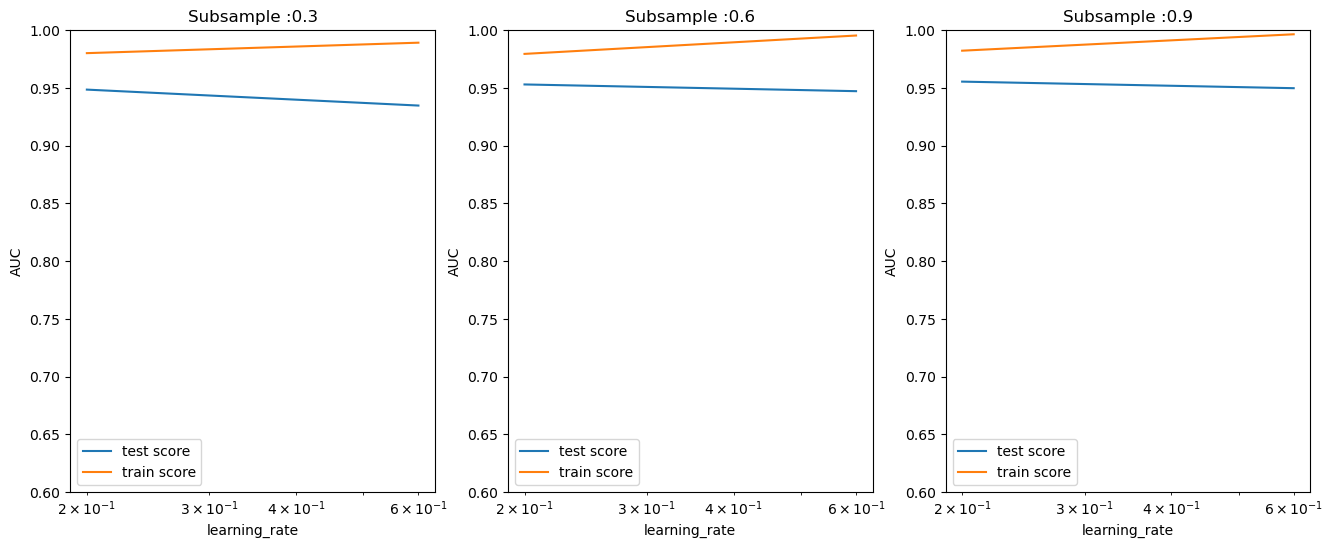

In [71]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {"learning_rate":[0.2, 0.6],
            "subsample":[0.3, 0.6, 0.9]}




for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]
    
    # plot df["param_learning_rate"] for df["mean_test_score"], df["mean_train_score"
    plt.plot(df['param_learning_rate'],df['mean_test_score'])
    plt.plot(df['param_learning_rate'],df['mean_train_score'])
    plt.xlabel("learning_rate")
    plt.ylabel("AUC")
    plt.title("Subsample :{0}".format(subsample))
    plt.legend(["test score","train score"])
    plt.ylim([0.6,1])
    plt.xscale('log')

    

The results show that a subsample size of 0.6 and learning_rate of about 0.2 seems optimal. 
Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters). 


Let's build a final model with the chosen hyperparameters.

In [72]:
# 4 chosen hyperparameters and use 'objective':'binary:logistic' which outputs probability rather than label, which we need for auc
params = {'learning_rate':0.2,
         'max_depth':2,
         'n_estimators':200,
         'subsample':0.6,
         'objective':'binary:logistic',
         'random_state':1}






#Instantiate XGBClassifier with params
XGB = XGBClassifier(params=params)



# fit model on training data
XGB.fit(X_train,y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'random_state': 1,
                      'subsample': 0.6}, ...)

In [76]:
# get prediction probability
y_pred = model.predict_proba(X_test)


#print to 10 prediction result

y_pred[:10]


array([[9.9999762e-01, 2.3850384e-06],
       [9.9997681e-01, 2.3205019e-05],
       [9.9999285e-01, 7.1295767e-06],
       [9.9978524e-01, 2.1477159e-04],
       [9.9994248e-01, 5.7545258e-05],
       [9.9999696e-01, 3.0614756e-06],
       [9.9992359e-01, 7.6433542e-05],
       [9.9999708e-01, 2.9036298e-06],
       [9.9962950e-01, 3.7048370e-04],
       [9.9869585e-01, 1.3041229e-03]], dtype=float32)

The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [89]:
# print roc_auc score
auc = metrics.roc_auc_score(y_test,y_pred[:,1])
auc



0.9627350427350426

Even after hyerparameter tuning we got same roc_auc score. Finally, let's also look at the feature importances.

In [78]:
# print feature importance for each column in  a dictionary form
importance = dict(zip(X_train.columns,model.feature_importances_))
importance




{'ip': 0.037970517,
 'app': 0.18047296,
 'device': 0.25417635,
 'os': 0.061070405,
 'channel': 0.12130905,
 'day_of_week': 0.049123943,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.04295167,
 'ip_count': 0.07025951,
 'ip_day_hour': 0.032868408,
 'ip_hour_channel': 0.041164912,
 'ip_hour_os': 0.03692177,
 'ip_hour_app': 0.02896896,
 'ip_hour_device': 0.042741563}

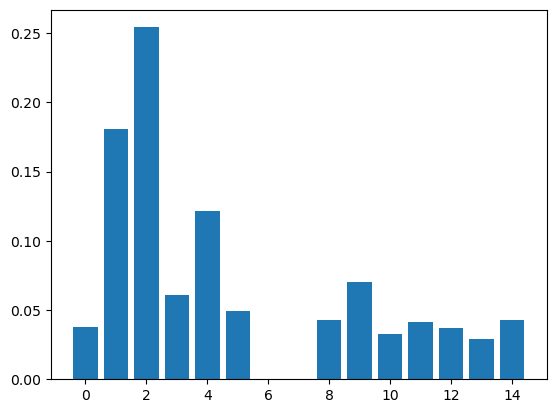

In [79]:
# plot feature importance for every column
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)
plt.show()




## **`4.  LightGBM`**

Reference doc: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Reference video: https://www.youtube.com/watch?v=Ph2nbuhOT04

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

**Advantages of Light GBM**

1. Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
2. Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
3. Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
4. Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.
5. Parallel learning supported.

I guess you must have got excited about the advantages of Light GBM. So lets get started with it

In [80]:
# import lightgbm
from lightgbm import LGBMClassifier

# import lightgbm as LGBMClassifier

# Instantiate LGBMClassifier with default hyperparameters and random_state=1
LGB = LGBMClassifier(random_state=1)

 
# fit model on training data
LGB.fit(X_train,y_train)






ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
# use predict_proba since we need probabilities to compute auc
y_pred =



#print top 10 y_pred result




In [ ]:
# evaluate predictions using roc_auc score
roc = 




Now lets tune above model. The exhaustive list of hyperparameters in LightGBM are https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

But lets run the LightGBM with previous selected hyperparamters i.e.

`'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'
         'random_state':1}`
         
Lets see if it improves

In [ ]:
# Define parameters as above
# params = {'learning_rate': 0.2,
#           'max_depth': 2, 
#           'n_estimators':200,
#           'subsample':0.6,
#          'objective':'binary:logistic',
#          'random_state':1}

# Instantiate XGBClassifier with params
LGB = 

 
# fit model on training data






In [ ]:
# use predict_proba since we need probabilities to compute auc
y_pred = 


# evaluate predictions using roc_auc score
roc = 




Oh man! even after tuning we have got lower AUC score. That's fine let us try our final model which is CatBoost.


## **`5. CatBoost`**

Reference doc: https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html4


CatBoost is a recently open-sourced machine learning algorithm from Yandex. It can easily integrate with deep learning frameworks like Google’s TensorFlow and Apple’s Core ML. It can work with diverse data types to help solve a wide range of problems that businesses face today. To top it up, it provides best-in-class accuracy.

It is especially powerful in two ways:

It yields state-of-the-art results without extensive data training typically required by other machine learning methods, and
Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.
“CatBoost” name comes from two words “Category” and “Boosting”.

As discussed, the library works well with multiple Categories of data, such as audio, text, image including historical data.

Reference video below -
dataset used: https://drive.google.com/file/d/1xzra_oUpq7sgOo8ImJtkmTqkDNmYvVMF/view?usp=sharing


## **`Watch Video 5 : CatBoost Training on GPU`**

In [82]:
# import CatBoostClassifier
from catboost import CatBoostClassifier



# Instantiate CatBoostClassifier with default hyperparameters and random_state=1
Cat = CatBoostClassifier(random_state=1)

 
# fit model on training data
Cat.fit(X_train,y_train)




Learning rate set to 0.06692
0:	learn: 0.5107371	total: 71.6ms	remaining: 1m 11s
1:	learn: 0.3708275	total: 81.6ms	remaining: 40.7s
2:	learn: 0.2729161	total: 92.1ms	remaining: 30.6s
3:	learn: 0.2003287	total: 101ms	remaining: 25.1s
4:	learn: 0.1525563	total: 109ms	remaining: 21.7s
5:	learn: 0.1183004	total: 117ms	remaining: 19.3s
6:	learn: 0.0926960	total: 124ms	remaining: 17.6s
7:	learn: 0.0741230	total: 130ms	remaining: 16.2s
8:	learn: 0.0608923	total: 137ms	remaining: 15.1s
9:	learn: 0.0465871	total: 144ms	remaining: 14.3s
10:	learn: 0.0387759	total: 151ms	remaining: 13.5s
11:	learn: 0.0329881	total: 157ms	remaining: 13s
12:	learn: 0.0289558	total: 165ms	remaining: 12.5s
13:	learn: 0.0251152	total: 172ms	remaining: 12.1s
14:	learn: 0.0217928	total: 178ms	remaining: 11.7s
15:	learn: 0.0196789	total: 185ms	remaining: 11.4s
16:	learn: 0.0177198	total: 191ms	remaining: 11.1s
17:	learn: 0.0161780	total: 198ms	remaining: 10.8s
18:	learn: 0.0150968	total: 204ms	remaining: 10.5s
19:	learn:

168:	learn: 0.0053489	total: 1.2s	remaining: 5.9s
169:	learn: 0.0053265	total: 1.21s	remaining: 5.9s
170:	learn: 0.0053160	total: 1.21s	remaining: 5.89s
171:	learn: 0.0053128	total: 1.22s	remaining: 5.88s
172:	learn: 0.0053005	total: 1.23s	remaining: 5.87s
173:	learn: 0.0052964	total: 1.23s	remaining: 5.86s
174:	learn: 0.0052910	total: 1.24s	remaining: 5.85s
175:	learn: 0.0052889	total: 1.25s	remaining: 5.84s
176:	learn: 0.0052783	total: 1.25s	remaining: 5.83s
177:	learn: 0.0052752	total: 1.26s	remaining: 5.82s
178:	learn: 0.0052715	total: 1.27s	remaining: 5.81s
179:	learn: 0.0052505	total: 1.27s	remaining: 5.8s
180:	learn: 0.0052450	total: 1.28s	remaining: 5.79s
181:	learn: 0.0052322	total: 1.29s	remaining: 5.78s
182:	learn: 0.0052282	total: 1.29s	remaining: 5.78s
183:	learn: 0.0052165	total: 1.3s	remaining: 5.77s
184:	learn: 0.0052135	total: 1.31s	remaining: 5.76s
185:	learn: 0.0052060	total: 1.31s	remaining: 5.75s
186:	learn: 0.0052030	total: 1.32s	remaining: 5.74s
187:	learn: 0.005

353:	learn: 0.0039707	total: 2.42s	remaining: 4.41s
354:	learn: 0.0039698	total: 2.42s	remaining: 4.4s
355:	learn: 0.0039604	total: 2.43s	remaining: 4.39s
356:	learn: 0.0039446	total: 2.44s	remaining: 4.39s
357:	learn: 0.0039375	total: 2.44s	remaining: 4.38s
358:	learn: 0.0039359	total: 2.45s	remaining: 4.37s
359:	learn: 0.0039323	total: 2.46s	remaining: 4.37s
360:	learn: 0.0039282	total: 2.46s	remaining: 4.36s
361:	learn: 0.0039165	total: 2.47s	remaining: 4.35s
362:	learn: 0.0039153	total: 2.48s	remaining: 4.35s
363:	learn: 0.0039099	total: 2.48s	remaining: 4.34s
364:	learn: 0.0039057	total: 2.49s	remaining: 4.33s
365:	learn: 0.0039031	total: 2.5s	remaining: 4.32s
366:	learn: 0.0039012	total: 2.5s	remaining: 4.32s
367:	learn: 0.0038920	total: 2.51s	remaining: 4.31s
368:	learn: 0.0038879	total: 2.52s	remaining: 4.3s
369:	learn: 0.0038841	total: 2.52s	remaining: 4.29s
370:	learn: 0.0038744	total: 2.53s	remaining: 4.29s
371:	learn: 0.0038739	total: 2.54s	remaining: 4.28s
372:	learn: 0.00

539:	learn: 0.0029903	total: 3.63s	remaining: 3.1s
540:	learn: 0.0029855	total: 3.64s	remaining: 3.09s
541:	learn: 0.0029756	total: 3.66s	remaining: 3.09s
542:	learn: 0.0029744	total: 3.66s	remaining: 3.08s
543:	learn: 0.0029707	total: 3.67s	remaining: 3.08s
544:	learn: 0.0029683	total: 3.68s	remaining: 3.07s
545:	learn: 0.0029608	total: 3.68s	remaining: 3.06s
546:	learn: 0.0029462	total: 3.69s	remaining: 3.06s
547:	learn: 0.0029459	total: 3.7s	remaining: 3.05s
548:	learn: 0.0029439	total: 3.7s	remaining: 3.04s
549:	learn: 0.0029432	total: 3.71s	remaining: 3.04s
550:	learn: 0.0029398	total: 3.72s	remaining: 3.03s
551:	learn: 0.0029230	total: 3.72s	remaining: 3.02s
552:	learn: 0.0029201	total: 3.73s	remaining: 3.01s
553:	learn: 0.0029164	total: 3.73s	remaining: 3.01s
554:	learn: 0.0029122	total: 3.74s	remaining: 3s
555:	learn: 0.0029113	total: 3.75s	remaining: 2.99s
556:	learn: 0.0029105	total: 3.75s	remaining: 2.99s
557:	learn: 0.0029063	total: 3.76s	remaining: 2.98s
558:	learn: 0.0029

725:	learn: 0.0023506	total: 4.86s	remaining: 1.83s
726:	learn: 0.0023496	total: 4.86s	remaining: 1.83s
727:	learn: 0.0023470	total: 4.87s	remaining: 1.82s
728:	learn: 0.0023466	total: 4.88s	remaining: 1.81s
729:	learn: 0.0023428	total: 4.88s	remaining: 1.81s
730:	learn: 0.0023426	total: 4.89s	remaining: 1.8s
731:	learn: 0.0023397	total: 4.9s	remaining: 1.79s
732:	learn: 0.0023354	total: 4.91s	remaining: 1.79s
733:	learn: 0.0023330	total: 4.91s	remaining: 1.78s
734:	learn: 0.0023283	total: 4.92s	remaining: 1.77s
735:	learn: 0.0023191	total: 4.93s	remaining: 1.77s
736:	learn: 0.0023173	total: 4.93s	remaining: 1.76s
737:	learn: 0.0023153	total: 4.94s	remaining: 1.75s
738:	learn: 0.0023151	total: 4.95s	remaining: 1.75s
739:	learn: 0.0023123	total: 4.95s	remaining: 1.74s
740:	learn: 0.0023077	total: 4.96s	remaining: 1.73s
741:	learn: 0.0023074	total: 4.97s	remaining: 1.73s
742:	learn: 0.0023047	total: 4.97s	remaining: 1.72s
743:	learn: 0.0023016	total: 4.98s	remaining: 1.71s
744:	learn: 0.

910:	learn: 0.0018944	total: 6.07s	remaining: 593ms
911:	learn: 0.0018908	total: 6.08s	remaining: 587ms
912:	learn: 0.0018875	total: 6.08s	remaining: 580ms
913:	learn: 0.0018873	total: 6.09s	remaining: 573ms
914:	learn: 0.0018851	total: 6.1s	remaining: 567ms
915:	learn: 0.0018850	total: 6.11s	remaining: 560ms
916:	learn: 0.0018843	total: 6.11s	remaining: 553ms
917:	learn: 0.0018823	total: 6.12s	remaining: 547ms
918:	learn: 0.0018779	total: 6.13s	remaining: 540ms
919:	learn: 0.0018775	total: 6.13s	remaining: 533ms
920:	learn: 0.0018754	total: 6.14s	remaining: 526ms
921:	learn: 0.0018742	total: 6.14s	remaining: 520ms
922:	learn: 0.0018737	total: 6.15s	remaining: 513ms
923:	learn: 0.0018718	total: 6.16s	remaining: 507ms
924:	learn: 0.0018717	total: 6.16s	remaining: 500ms
925:	learn: 0.0018688	total: 6.17s	remaining: 493ms
926:	learn: 0.0018649	total: 6.18s	remaining: 486ms
927:	learn: 0.0018624	total: 6.18s	remaining: 480ms
928:	learn: 0.0018579	total: 6.19s	remaining: 473ms
929:	learn: 0

Now lets tune above model. The exhaustive list of hyperparameters in LightGBM are https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

But lets run the CatBoost with previous selected hyperparamters i.e

`learning_rate=0.2,
max_depth=2,
n_estimators=200,
subsample=0.6,
random_state=1`

and lets see if it improves

In [84]:

# Instantiate CatBoostClassifier with params
Cat = CatBoostClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, subsample=0.6, random_state=1)

 
# fit model on training data
Cat.fit(X_train,y_train)





0:	learn: 0.2613770	total: 8.99ms	remaining: 1.79s
1:	learn: 0.1107299	total: 15ms	remaining: 1.48s
2:	learn: 0.0567450	total: 21ms	remaining: 1.38s
3:	learn: 0.0348243	total: 27.3ms	remaining: 1.33s
4:	learn: 0.0248349	total: 32.6ms	remaining: 1.27s
5:	learn: 0.0195141	total: 37.8ms	remaining: 1.22s
6:	learn: 0.0164514	total: 42.4ms	remaining: 1.17s
7:	learn: 0.0151273	total: 46.9ms	remaining: 1.13s
8:	learn: 0.0137331	total: 51.5ms	remaining: 1.09s
9:	learn: 0.0130939	total: 55.6ms	remaining: 1.06s
10:	learn: 0.0129013	total: 60.5ms	remaining: 1.04s
11:	learn: 0.0124680	total: 64.7ms	remaining: 1.01s
12:	learn: 0.0121171	total: 69.6ms	remaining: 1s
13:	learn: 0.0120108	total: 74.6ms	remaining: 991ms
14:	learn: 0.0118553	total: 79.6ms	remaining: 981ms
15:	learn: 0.0117221	total: 83.6ms	remaining: 962ms
16:	learn: 0.0115269	total: 87.9ms	remaining: 946ms
17:	learn: 0.0113924	total: 92.9ms	remaining: 939ms
18:	learn: 0.0113005	total: 97.8ms	remaining: 932ms
19:	learn: 0.0112542	total: 1

168:	learn: 0.0068065	total: 817ms	remaining: 150ms
169:	learn: 0.0068044	total: 822ms	remaining: 145ms
170:	learn: 0.0067935	total: 828ms	remaining: 140ms
171:	learn: 0.0067910	total: 833ms	remaining: 136ms
172:	learn: 0.0067890	total: 838ms	remaining: 131ms
173:	learn: 0.0067836	total: 842ms	remaining: 126ms
174:	learn: 0.0067717	total: 847ms	remaining: 121ms
175:	learn: 0.0067692	total: 852ms	remaining: 116ms
176:	learn: 0.0067651	total: 857ms	remaining: 111ms
177:	learn: 0.0067593	total: 861ms	remaining: 106ms
178:	learn: 0.0067556	total: 866ms	remaining: 102ms
179:	learn: 0.0067486	total: 870ms	remaining: 96.7ms
180:	learn: 0.0067246	total: 875ms	remaining: 91.9ms
181:	learn: 0.0067204	total: 879ms	remaining: 87ms
182:	learn: 0.0067011	total: 884ms	remaining: 82.1ms
183:	learn: 0.0066990	total: 889ms	remaining: 77.3ms
184:	learn: 0.0066970	total: 894ms	remaining: 72.5ms
185:	learn: 0.0066785	total: 899ms	remaining: 67.7ms
186:	learn: 0.0066699	total: 904ms	remaining: 62.8ms
187:	l

In [88]:
# use predict_proba since we need probabilities to compute auc
y_pred = Cat.predict_proba(X_test)


# evaluate predictions using roc_auc score
roc =metrics.roc_auc_score(y_test,y_pred[:,1])
print("AUC: %.2f%%"%(roc*100.0))


AUC: 96.27%


Wohoo! oh yes. Your final model can come to your rescue. CatBoost gives slightly better result than all other models which we tried till now.


Recommendations for training:
- We have used only a fraction of the training set (train_sample, 100k rows), the full training data on Kaggle (train.csv) has about 180 million rows. You'll get good results only if you train the model on a significant portion of the training dataset.  
- Because of the size, you'll need to use Colab kernels to train the model on full training data. Colab kernels provide powerful computation capacities on cloud (for free). 
- Even on the kernel, you may need to use a portion of the training dataset (try using the last 20-30 million rows).
- Make sure you save memory by following some tricks and best practices, else you won't be able to train the model at all on a large dataset.


Finally in this assignment you have learned about various boosting techniques and in previous assignment you had learned about Bagging techniques. We hope you understood the difference between them and their use.

You can refer below videos to know interesting Interview questions on Boosting techniques. 

https://www.youtube.com/watch?v=EHewTwtYcgE




From above you can see that most of the International footbal tournament were on sunday. Such small small analysis becomes usefull for our machine learning problems to solve.

All these feature engineering techniques becomes very important to bring good insights and results for any machine learning problems, hence we hope that you understand the importance of feature engineering as part of data science.

---------------------
# Peaceable with ensemble! Congrats..you have completed your ML Ensemble challenge
---------------------


# FeedBack
We hope you’ve enjoyed this course so far. We’re committed to help you use "AI for All" course to its full potential, so that you have a great learning experience. And that’s why we need your help in form of a feedback here.

Please fill this feedback form https://zfrmz.in/MtRG5oWXBdesm6rmSM7N